In [266]:
from spineq.optimise import get_optimisation_inputs
from spineq.utils import coverage_matrix
from spineq.plotting import plot_optimisation_result
from spineq.data_fetcher import get_oa_shapes, get_oa_centroids

import pygmo as pg

import numpy as np
import pandas as pd

from time import time

In [8]:
n_sensors = 20
theta = 500

population_weight = 1
workplace_weight = 0
pop_age_groups = {
    "pop_total": {"min": 0, "max": 90, "weight": 1},
    "pop_children": {"min": 0, "max": 16, "weight": 0},
    "pop_elderly": {"min": 70, "max": 90, "weight": 0},
}

## Get Input Data

In [9]:
data = get_optimisation_inputs(
    population_weight=population_weight,
    workplace_weight=workplace_weight,
    pop_age_groups=pop_age_groups,
    combine=True,
)

data.keys()

dict_keys(['oa11cd', 'oa_x', 'oa_y', 'oa_weight'])

## PyGMO: vector of 0/1s for sensor at location or not

Fails to even meet constraints. But assume it has to "learn" how to make the vector sum up to n_sensors, which seems difficult.

In [17]:
# PyGMO User Defined Problem
class population_optimisation:
    def __init__(self, oa_x, oa_y, oa_weight,
                 n_sensors, theta):
        
        self.n_sensors = n_sensors
        self.oa_weight = oa_weight
        self.coverage = coverage_matrix(oa_x, oa_y, theta=theta)
        
        # dimension of problem = number of candidate sensor locations
        self.dim = len(oa_x)
          
    def fitness(self, sensors):
        """
        PyGMO required function.
        The objective function to minimise. And constraints to evaluate.
        """
        # only keep coverages due to output areas where a sensor is present
        mask_cov = np.multiply(self.coverage, sensors[np.newaxis, :])

        # coverage at each output area = coverage due to nearest sensor
        max_mask_cov = np.max(mask_cov, axis=1)
        
        # Total population-weighted coverage of solution = our objective
        fitness_sensors = -(self.oa_weight * max_mask_cov).sum() / self.oa_weight.sum()

        # constraint: have n_sensors sensors
        # equality constraints: must equal zero
        constraint_n_sensors = sensors.sum() - self.n_sensors
        
        return [fitness_sensors, constraint_n_sensors]
    
    def get_bounds(self):
        """
        PyGMO required function.
        Defines min and max value for each parameter.
        """
        return ([0]*self.dim, [1]*self.dim)
    
    def get_nec(self):
        """PyGMO function.
        Defines number of equality constraints."""
        return 1
    
    def get_nix(self):
        """
        PyGMO function.
        Number of integer dimensions.
        """
        return self.dim
    
    def gradient(self, x):
        return pg.estimate_gradient_h(lambda x: self.fitness(x), x)
    


In [23]:
# Build problem
pop_opt = population_optimisation(
    data["oa_x"],
    data["oa_y"],
    data["oa_weight"],
    n_sensors,
    theta,
)

prob = pg.problem(pop_opt)

print(prob)

Problem name: <class '__main__.population_optimisation'>
	Global dimension:			952
	Integer dimension:			952
	Fitness dimension:			2
	Number of objectives:			1
	Equality constraints dimension:		1
	Inequality constraints dimension:	0
	Tolerances on constraints: [0]
	Lower bounds: [0, 0, 0, 0, 0, ... ]
	Upper bounds: [1, 1, 1, 1, 1, ... ]
	Has batch fitness evaluation: false

	Has gradient: true
	User implemented gradient sparsity: false
	Expected gradients: 1904
	Has hessians: false
	User implemented hessians sparsity: false

	Fitness evaluations: 0
	Gradient evaluations: 0

	Thread safety: none



In [24]:
# Create algorithm to solve problem with
algo = pg.algorithm(uda = pg.gaco(gen=100))
algo.set_verbosity(1)
print(algo)

# population of problems
pop = pg.population(prob=prob, size=100)


Algorithm name: GACO: Ant Colony Optimization [stochastic]
	Thread safety: basic

Extra info:
	Generations: 100
	Accuracy parameter: 0.01
	Improvement stopping criterion: 100000
	Evaluation stopping criterion: 100000
	Focus parameter: 0
	Kernel: 63
	Oracle parameter: 0
	Pseudo-random number generator (Marsenne Twister 19937): 1046335709 3251940402 2858756183 1389454988 106556069 2794381342 487679762 830753825 1456910861 374385349 3231304899 3833628619 98015732 3575599441 2837313384 1042306785 493334485 3251919898 784381679 1752634206 2347858831 1312764854 1335711305 1480036991 3032758734 4176279957 573161032 1698994819 3159263078 892071569 787986515 665134046 2808804534 3943882533 4192690208 3484461298 3316817977 1892565255 827710852 688392507 2713270127 1823945514 2027303713 868109259 4147153475 1206045549 3679129034 3682337148 2469563979 3507893246 2273306627 2896564632 1881562102 2115663784 2082055907 2560346465 3656478535 3953674765 4150834624 3790213418 682014313 2319657130 204426

In [25]:
# solve problem
pop = algo.evolve(pop)

print("f evals", pop.problem.get_fevals())
print("g evals", pop.problem.get_gevals())
print("champion f", pop.champion_f)
print("n_sensors", pop.champion_x.sum())
print("min sensors at location", pop.champion_x.min())
print("max sensors at location", pop.champion_x.max())

f evals 10100
g evals 0
champion f [ -0.79826004 392.        ]
n_sensors 412.0
min sensors at location 0.0
max sensors at location 1.0


In [38]:
def pygmo_result_dict(pop, data, theta):
    """Convert PyGMO optimised population into result dict
    with format needed for plot_optimisation_result.
    pop: evolved population
    data: input optimisation data from get_optimisation_inputs
    theta: coverage decay rate parameter
    """
    sensors = pop.champion_x

    coverage = coverage_matrix(data["oa_x"], data["oa_y"], theta=theta)
    mask_cov = np.multiply(coverage, sensors[np.newaxis, :])
    oa_coverage = np.max(mask_cov, axis=1)

    n_poi = len(data["oa_x"])

    sensors = [
        {"x": data["oa_x"][i], "y": data["oa_y"][i], "oa11cd": data["oa11cd"][i]}
        for i in range(n_poi)
        if sensors[i] == 1
    ]

    oa_coverage = [
        {"oa11cd": data["oa11cd"][i], "coverage": oa_coverage[i]} for i in range(n_poi)
    ]

    total_coverage = - pop.champion_f[0]

    result = {"sensors": sensors, "oa_coverage": oa_coverage, "total_coverage": total_coverage}
    
    return result

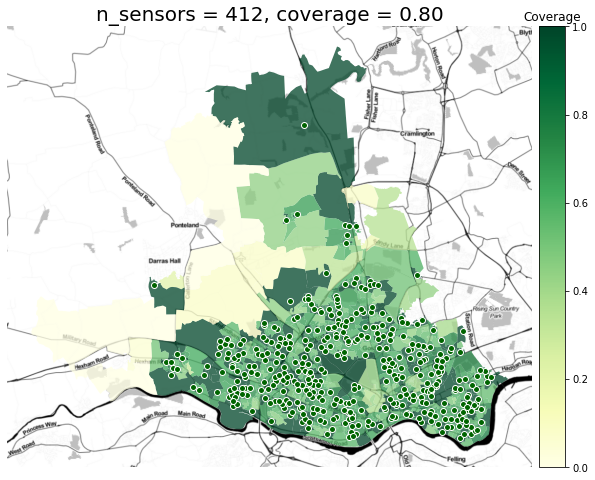

In [37]:
result = pygmo_result_dict(pop, data, theta)

plot_optimisation_result(result)

## PyGMO: Sensors at any arbitrary position (not only output area centroids)

In [159]:
# PyGMO User Defined Problem
class population_optimisation:
    def __init__(self, oa_x, oa_y, oa_weight,
                 n_sensors, theta):
        
        self.n_sensors = n_sensors
        self.oa_weight = oa_weight
        self.oa_x = oa_x
        self.oa_y = oa_y
        self.theta = theta
        
        self.min_x = oa_x.min()
        self.min_y = oa_y.min()
        self.max_x = oa_x.max()
        self.max_y = oa_y.max()
          
    def fitness(self, sensors):
        """
        PyGMO required function.
        The objective function to minimise. And constraints to evaluate.
        """
        # extract sensor x and y positions
        sensors_x = sensors[0::2]
        sensors_y = sensors[1::2]

        # coverage at each output area due to each sensor
        coverage = coverage_matrix(sensors_x, sensors_y,
                                   self.oa_x, self.oa_y, theta=self.theta)
        
        # coverage at each output area = coverage due to nearest sensor
        max_cov = np.max(coverage, axis=0)
        
        # Total population-weighted coverage of solution = our objective
        fitness_sensors = -(self.oa_weight * max_cov).sum() / self.oa_weight.sum()
        
        return [fitness_sensors]
    
    def get_bounds(self):
        """
        PyGMO required function.
        Defines min and max value for each parameter.
        """
        return ([self.min_x, self.min_y]*self.n_sensors,
                [self.max_x, self.max_y]*self.n_sensors)
    
    def gradient(self, x):
        return pg.estimate_gradient_h(lambda x: self.fitness(x), x)

In [160]:
# Build problem
pop_opt = population_optimisation(
    data["oa_x"],
    data["oa_y"],
    data["oa_weight"],
    n_sensors,
    theta,
)

prob = pg.problem(pop_opt)

print(prob)

Problem name: <class '__main__.population_optimisation'>
	Global dimension:			40
	Integer dimension:			0
	Fitness dimension:			1
	Number of objectives:			1
	Equality constraints dimension:		0
	Inequality constraints dimension:	0
	Lower bounds: [413067, 563224, 413067, 563224, 413067, ... ]
	Upper bounds: [429850, 577386, 429850, 577386, 429850, ... ]
	Has batch fitness evaluation: false

	Has gradient: true
	User implemented gradient sparsity: false
	Expected gradients: 40
	Has hessians: false
	User implemented hessians sparsity: false

	Fitness evaluations: 0
	Gradient evaluations: 0

	Thread safety: none



In [163]:
# Create algorithm to solve problem with
algo = pg.algorithm(uda = pg.gaco(gen=100))
algo.set_verbosity(1)
print(algo)

# population of problems
pop = pg.population(prob=prob, size=100)

Algorithm name: GACO: Ant Colony Optimization [stochastic]
	Thread safety: basic

Extra info:
	Generations: 100
	Accuracy parameter: 0.01
	Improvement stopping criterion: 100000
	Evaluation stopping criterion: 100000
	Focus parameter: 0
	Kernel: 63
	Oracle parameter: 0
	Pseudo-random number generator (Marsenne Twister 19937): 1997184170 297030264 1569636698 4232641514 3338277873 4176765055 4084231410 3695113244 1448339267 548048659 392207753 137066520 3843242372 823128400 1016988830 1126326373 3034680196 1766900207 2049368312 847971152 751705764 36952777 1711923811 347783873 3744407357 1208058255 2848922400 3928548997 455780602 2736288959 1548366767 4038099397 2139105598 2556165372 1772142168 1924643392 418399433 421114994 2949853984 580804241 722331741 73495002 4116026668 2145583798 939852127 3847119272 970853285 2522408264 1624051810 627143232 89543538 2916412973 3754041279 1488331105 3780610838 1787501696 2930395165 379587444 3547437310 563855628 4095120888 1628012356 4106101623 942

In [164]:
# solve problem
pop = algo.evolve(pop)

print("f evals", pop.problem.get_fevals())
print("g evals", pop.problem.get_gevals())
print("champion f", pop.champion_f)
print("sensors", pop.champion_x)

f evals 10100
g evals 0
champion f [-0.24382549]
sensors [426124.27091971 568119.19053053 428366.79929735 567371.35666994
 427242.24080118 566077.01729563 421936.95381504 564032.09166905
 422583.42924598 564943.05022401 424943.12832062 576920.55234305
 424984.76030512 567822.24150292 420513.62975648 575985.21464943
 422021.35267208 566259.53531065 422271.41573555 564562.23331218
 425572.76836311 564640.02984742 429147.08008749 566153.38917601
 422142.0038604  569314.20609511 424206.29921205 564845.82018059
 426582.98039245 565194.63535942 422555.57151366 565680.45192066
 421964.75838528 572747.9136673  425902.49979047 565482.78961299
 415941.54277502 567138.49112934 418650.85853481 567055.75810713]


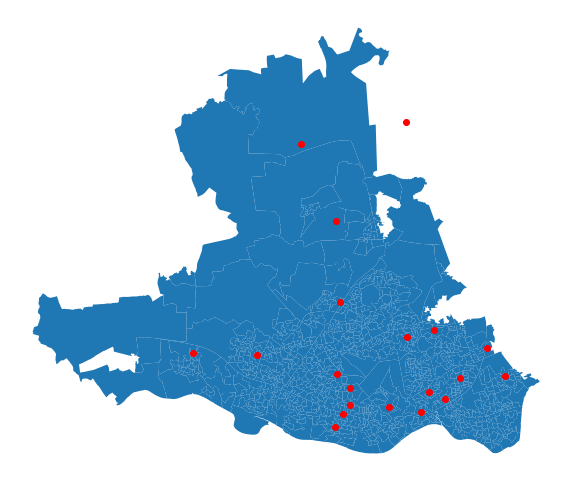

In [165]:
oa_shapes = get_oa_shapes()

ax = oa_shapes.plot(figsize=(10,10))
ax.set_axis_off()

sensors = pop.champion_x
sensors_x = sensors[0::2]
sensors_y = sensors[1::2]
ax.scatter(sensors_x,sensors_y, color='r')

## PyGMO Sensors by Index

One decision variable for each sensor to be placed, variable value is index of location.

In [189]:
# PyGMO User Defined Problem
class population_optimisation:
    def __init__(self, oa_x, oa_y, oa_weight,
                 n_sensors, theta):
        
        self.n_sensors = n_sensors
        self.n_locations = len(oa_x)
        self.oa_weight = oa_weight
        self.coverage = coverage_matrix(oa_x, oa_y, theta=theta)
          
    def fitness(self, sensors_idx):
        """
        PyGMO required function.
        The objective function to minimise. And constraints to evaluate.
        """
        # Construct sensors vector from indices
        sensors = np.zeros(self.n_locations)
        sensors[sensors_idx.astype(int)] = 1
        
        # only keep coverages due to output areas where a sensor is present
        mask_cov = np.multiply(self.coverage, sensors[np.newaxis, :])

        # coverage at each output area = coverage due to nearest sensor
        max_mask_cov = np.max(mask_cov, axis=1)
        
        # Total population-weighted coverage of solution = our objective
        fitness_sensors = -(self.oa_weight * max_mask_cov).sum() / self.oa_weight.sum()

        # constraint: all sensors at different locations
        # equality constraints: must equal zero
        #constraint_sensors = self.n_sensors - len(set(sensors_idx))
        
        return [fitness_sensors]#, constraint_sensors]
    
    def get_bounds(self):
        """
        PyGMO required function.
        Defines min and max value for each parameter.
        """
        return ([0]*self.n_sensors, [self.n_locations-1]*self.n_sensors)
    
    def get_nec(self):
        """PyGMO function.
        Defines number of equality constraints."""
        return 0 #1
    
    def get_nix(self):
        """
        PyGMO function.
        Number of integer dimensions.
        """
        return self.n_sensors
    
    def gradient(self, x):
        return pg.estimate_gradient_h(lambda x: self.fitness(x), x)
    


In [190]:
# Build problem
pop_opt = population_optimisation(
    data["oa_x"],
    data["oa_y"],
    data["oa_weight"],
    n_sensors,
    theta,
)

prob = pg.problem(pop_opt)

print(prob)

Problem name: <class '__main__.population_optimisation'>
	Global dimension:			20
	Integer dimension:			20
	Fitness dimension:			1
	Number of objectives:			1
	Equality constraints dimension:		0
	Inequality constraints dimension:	0
	Lower bounds: [0, 0, 0, 0, 0, ... ]
	Upper bounds: [951, 951, 951, 951, 951, ... ]
	Has batch fitness evaluation: false

	Has gradient: true
	User implemented gradient sparsity: false
	Expected gradients: 20
	Has hessians: false
	User implemented hessians sparsity: false

	Fitness evaluations: 0
	Gradient evaluations: 0

	Thread safety: none



In [191]:
# Create algorithm to solve problem with
algo = pg.algorithm(uda = pg.gaco(gen=100))
algo.set_verbosity(1)
print(algo)

# population of problems
pop = pg.population(prob=prob, size=100)


Algorithm name: GACO: Ant Colony Optimization [stochastic]
	Thread safety: basic

Extra info:
	Generations: 100
	Accuracy parameter: 0.01
	Improvement stopping criterion: 100000
	Evaluation stopping criterion: 100000
	Focus parameter: 0
	Kernel: 63
	Oracle parameter: 0
	Pseudo-random number generator (Marsenne Twister 19937): 1521529295 461333575 3084750597 4179963078 2248349373 3114086496 76974256 1532632439 3666593174 1223995602 2498735689 1860363938 1063729499 921195508 977449810 763732329 788062077 2419396962 1155283698 655641842 2060311950 28504192 30237334 2581867333 4112454171 4103666577 3623510708 463331662 1946067426 961370540 70610170 3007039681 1985712143 2325304231 2713996603 139786400 250853188 102150649 1979807843 4205768913 3013829890 327407913 2119867991 4107697689 3436292718 2816971310 3133814666 3459756247 1868969940 168297530 3573724436 614187334 2630596306 2699325509 3223800633 1566095385 1999468976 1525136398 1501182245 1976094575 54375586 2507208231 3226331607 170

In [192]:
# solve problem
pop = algo.evolve(pop)

print("f evals", pop.problem.get_fevals())
print("g evals", pop.problem.get_gevals())
print("champion f", pop.champion_f)
print("n_sensors", pop.champion_x.sum())
print("min sensors at location", pop.champion_x.min())
print("max sensors at location", pop.champion_x.max())

f evals 10100
g evals 0
champion f [-0.29301901]
n_sensors 7331.0
min sensors at location 21.0
max sensors at location 842.0


In [193]:
def pygmo_result_dict(pop, data, theta):
    """Convert PyGMO optimised population into result dict
    with format needed for plot_optimisation_result.
    pop: evolved population
    data: input optimisation data from get_optimisation_inputs
    theta: coverage decay rate parameter
    """
    
    n_poi = len(data["oa_x"])

    sensors_idx = pop.champion_x
    
    # Construct sensors vector from indices
    sensors = np.zeros(n_poi)
    sensors[sensors_idx.astype(int)] = 1
    
    coverage = coverage_matrix(data["oa_x"], data["oa_y"], theta=theta)
    mask_cov = np.multiply(coverage, sensors[np.newaxis, :])
    oa_coverage = np.max(mask_cov, axis=1)

    sensors = [
        {"x": data["oa_x"][i], "y": data["oa_y"][i], "oa11cd": data["oa11cd"][i]}
        for i in range(n_poi)
        if sensors[i] == 1
    ]

    oa_coverage = [
        {"oa11cd": data["oa11cd"][i], "coverage": oa_coverage[i]} for i in range(n_poi)
    ]

    total_coverage = - pop.champion_f[0]

    result = {"sensors": sensors, "oa_coverage": oa_coverage, "total_coverage": total_coverage}
    
    return result

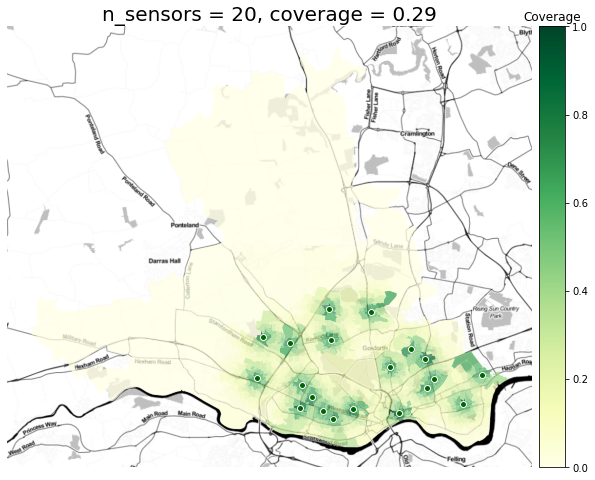

In [194]:
result = pygmo_result_dict(pop, data, theta)

plot_optimisation_result(result)

## Compare Algorithms

In [252]:
algorithms = [
    {"name": "Extended Ant Colony Optimization (GACO)", "fn": pg.gaco},
    {"name": "Differential Evolution (DE)", "fn":  pg.de},
    {"name": "Self-adaptive DE (jDE and iDE)", "fn":  pg.sade},
    {"name": "Self-adaptive DE (de_1220 aka pDE)", "fn":  pg.de1220},
    {"name": "Grey wolf optimizer (GWO)", "fn":  pg.gwo},
    {"name": "Improved Harmony Search", "fn":  pg.ihs},
    {"name": "Particle Swarm Optimization (PSO)", "fn":  pg.pso},
    {"name": "Particle Swarm Optimization Generational (GPSO)", "fn":  pg.pso_gen},
    {"name": "(N+1)-ES Simple Evolutionary Algorithm", "fn":  pg.sea},
    {"name": "Simple Genetic Algorithm", "fn":  pg.sga},
    {"name": "Corana’s Simulated Annealing (SA)", "fn":  pg.simulated_annealing},
    {"name": "Artificial Bee Colony (ABC)", "fn":  pg.bee_colony},
    {"name": "Covariance Matrix Adaptation Evo. Strategy (CMA-ES)", "fn":  pg.cmaes},
    {"name": "Exponential Evolution Strategies (xNES)", "fn":  pg.xnes},
]

In [253]:
def run_opt(prob, uda, gen=100, size=100):
    start_time = time()
    
    # Create algorithm to solve problem with
    algo = pg.algorithm(uda = uda(gen=gen))
    algo.set_verbosity(1)

    # population of problems
    pop = pg.population(prob=prob, size=size)

    # solve problem
    pop = algo.evolve(pop)

    elapsed = time() - start_time
    score = -pop.champion_f[0]
    
    return score, elapsed

In [259]:
# Build problem
pop_opt = population_optimisation(
    data["oa_x"],
    data["oa_y"],
    data["oa_weight"],
    n_sensors,
    theta,
)

prob = pg.problem(pop_opt)
print(prob)
print("-"*30)

for i, alg in enumerate(algorithms):
    print("Doing",alg["name"])
    try:
        score, elapsed = run_opt(prob, alg["fn"])
        algorithms[i]["score"] = score
        algorithms[i]["time"] = elapsed
        print("Score:", score)
        print("Time:", elapsed)
    except Exception as e:
        print(f"Error {e}")
    
    print("-"*30)

Problem name: <class '__main__.population_optimisation'>
	Global dimension:			20
	Integer dimension:			20
	Fitness dimension:			1
	Number of objectives:			1
	Equality constraints dimension:		0
	Inequality constraints dimension:	0
	Lower bounds: [0, 0, 0, 0, 0, ... ]
	Upper bounds: [951, 951, 951, 951, 951, ... ]
	Has batch fitness evaluation: false

	Has gradient: true
	User implemented gradient sparsity: false
	Expected gradients: 20
	Has hessians: false
	User implemented hessians sparsity: false

	Fitness evaluations: 0
	Gradient evaluations: 0

	Thread safety: none

------------------------------
Doing Extended Ant Colony Optimization (GACO)
Score: 0.2888608502728504
Time: 20.641813039779663
------------------------------
Doing Differential Evolution (DE)
Score: 0.3059836420363781
Time: 25.863367795944214
------------------------------
Doing Self-adaptive DE (jDE and iDE)
Score: 0.3126018154679892
Time: 24.215542793273926
------------------------------
Doing Self-adaptive DE (de_122

In [267]:
df = pd.DataFrame(algorithms)

print("BEST SCORE:")
display(df.sort_values(by="score", ascending=False).head())

print("FASTEST:")
display(df.sort_values(by="time", ascending=True).head())

BEST SCORE:


,name,fn,score,time
9,Simple Genetic Algorithm,<class 'pygmo.core.sga'>,0.325617,17.965706
11,Artificial Bee Colony (ABC),<class 'pygmo.core.bee_colony'>,0.314855,38.602106
3,Self-adaptive DE (de_1220 aka pDE),<class 'pygmo.core.de1220'>,0.314533,23.306483
2,Self-adaptive DE (jDE and iDE),<class 'pygmo.core.sade'>,0.312602,24.215543
1,Differential Evolution (DE),<class 'pygmo.core.de'>,0.305984,25.863368


FASTEST:


,name,fn,score,time
8,(N+1)-ES Simple Evolutionary Algorithm,<class 'pygmo.core.sea'>,0.298102,0.384395
5,Improved Harmony Search,<class 'pygmo.core.ihs'>,0.282458,0.417790
9,Simple Genetic Algorithm,<class 'pygmo.core.sga'>,0.325617,17.965706
7,Particle Swarm Optimization Generational (GPSO),<class 'pygmo.core.pso_gen'>,0.294954,18.362200
6,Particle Swarm Optimization (PSO),<class 'pygmo.core.pso'>,0.289968,18.649138


## Results
- Simple genetic algorithm (pg.sga) - generally best score 
- Simple evolutionary algorithm (pg.sea) - good score and generally fastest

## Simple Genetic Algorithm

In [271]:
# Create algorithm to solve problem with
algo = pg.algorithm(uda = pg.sga(gen=200))
algo.set_verbosity(1)
print(algo)

# population of problems
pop = pg.population(prob=prob, size=200)


Algorithm name: SGA: Genetic Algorithm [stochastic]
	Thread safety: basic

Extra info:
	Number of generations: 200
	Crossover:
		Type: exponential
		Probability: 0.9
	Mutation:
		Type: polynomial
		Probability: 0.02
		Distribution index: 1
	Selection:
		Type: tournament
		Tournament size: 2
	Seed: 1435420914
	Verbosity: 1


In [272]:
# solve problem
pop = algo.evolve(pop)

print("f evals", pop.problem.get_fevals())
print("g evals", pop.problem.get_gevals())
print("champion f", pop.champion_f)
print("n_sensors", pop.champion_x.sum())
print("min sensors at location", pop.champion_x.min())
print("max sensors at location", pop.champion_x.max())

f evals 40200
g evals 0
champion f [-0.33502303]
n_sensors 6170.0
min sensors at location 7.0
max sensors at location 842.0


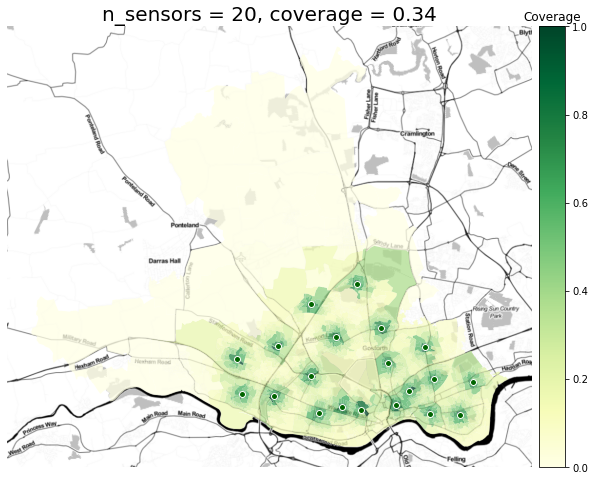

In [273]:
result = pygmo_result_dict(pop, data, theta)

plot_optimisation_result(result)

## Simple Evolutionary Algorithm

In [277]:
# Create algorithm to solve problem with
algo = pg.algorithm(uda = pg.sea(gen=20000))
algo.set_verbosity(1)
print(algo)

# population of problems
pop = pg.population(prob=prob, size=1000)


Algorithm name: SEA: (N+1)-EA Simple Evolutionary Algorithm [stochastic]
	Thread safety: basic

Extra info:
	Generations: 20000
	Verbosity: 1
	Seed: 570736556


In [278]:
# solve problem
pop = algo.evolve(pop)

print("f evals", pop.problem.get_fevals())
print("g evals", pop.problem.get_gevals())
print("champion f", pop.champion_f)
print("n_sensors", pop.champion_x.sum())
print("min sensors at location", pop.champion_x.min())
print("max sensors at location", pop.champion_x.max())

f evals 21000
g evals 0
champion f [-0.33519742]
n_sensors 8447.02021083528
min sensors at location 19.831329116682138
max sensors at location 859.861325236802


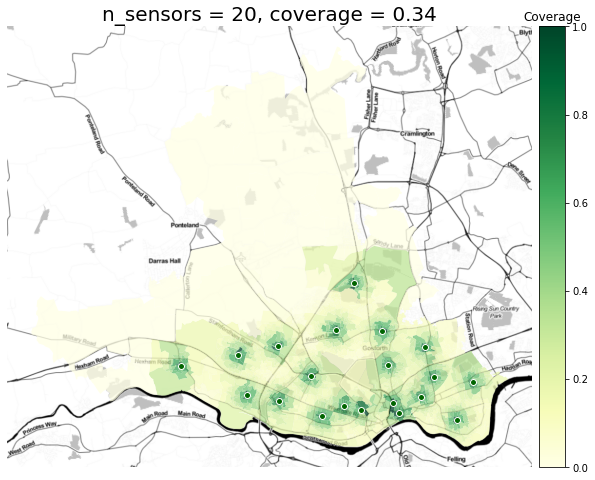

In [279]:
result = pygmo_result_dict(pop, data, theta)

plot_optimisation_result(result)